# CeNN entrenada con ABC

Entrenamiento de una CeNN utilizando el método ABC

## Librerías

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from time import time
import pandas as pd 

In [2]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "), 
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True


## Función CeNN

In [4]:
def CeNN(matEnt, plantillas, dim, sal = None, edo = None, tmax = 5, h = 0.001):
    """
    Función que crea una Red Nueronal Celular utilizando Tensorflow
    """
    matSal = matEnt
    matEdo = matEnt
    # Crea las plantillas
    pA = np.array([[plantillas[0], plantillas[1], plantillas[2]],
                   [plantillas[3], plantillas[4], plantillas[3]],
                   [plantillas[2], plantillas[1], plantillas[0]]])
    
    pB = np.array([[plantillas[5], plantillas[6], plantillas[7]],
                   [plantillas[8], plantillas[9], plantillas[8]],
                   [plantillas[7], plantillas[6], plantillas[5]]])
    
    tA = tf.convert_to_tensor(pA, dtype = tf.float32)
    tA = tf.reshape(tA, shape = [3, 3, 1, 1])
    tB = tf.convert_to_tensor(pB, dtype = tf.float32)
    tB = tf.reshape(tB, shape = [3, 3, 1, 1])
    tI = tf.convert_to_tensor(plantillas[10], dtype = tf.float32)

    # Calcula la matriz Iij
    matIij = tf.nn.conv2d(matEnt, tB, strides = [1, 1, 1, 1], padding = "SAME")
    #matIij = tf.reshape(matIij, shape = [dim[0], dim[1]])
    matIij = tf.add(matIij, tI)

    # Inicializa la variable de tiempo
    t = 0

    # Comienza con el calculo de la CeNN
    while(t < tmax):
        # Calcula Fij
        matFij = tf.nn.conv2d(matSal, tA, strides = [1, 1, 1, 1], padding= "SAME")
        # Calcula el Estado
        matEdo = tf.add(matEdo, tf.multiply(h, tf.add(matFij, tf.subtract(matIij, matEdo))))
        # Calcula la Salida
        matSal = tf.multiply(0.5, tf.subtract(tf.abs(tf.add(matEdo, 1.0)), tf.abs(tf.subtract(matEdo, 1.0))))
        # Calcula el siguiente paso
        t = t + h
    # Redimensiona
    matSal = tf.reshape(matSal, shape = [dim[0], dim[1]])
    # Regresa la salida
    return matSal

## Funciones ABC

In [5]:
def best(x, fitx):
    # Centroide
    xo = np.mean(x, axis = 0)
    # Ordenamiento
    fitSort = sorted(enumerate(fitx), key=lambda z:z[1], reverse=True)
    # Indices
    indMin = fitSort[-1][0]
    indH1 = fitSort[0][0]
    indH2 = fitSort[1][0]
    # Valores Fit
    fitMin = fitSort[-1][1]
    fitH1 = fitSort[0][1]
    fitH2 = fitSort[1][1]
    # Valores X
    xMin = x[indMin]
    xH1 = x[indH1]
    xH2 = x[indH2]
    #print("fitMin = {}, fitx[ind] = {}, fitx = {}".format(fitMin, fitx[indMin], fitx))
    return [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2]

In [6]:
def correlacion(imgEnt, imgObj):
    # Convierte la imgEnt a valores entre 0 y 255
    img = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgEnt)))

    zPmean = tf.math.reduce_mean(img)
    tPmean = tf.math.reduce_mean(imgObj)

    numerador = tf.math.reduce_sum(tf.multiply(tf.subtract(img, zPmean), tf.subtract(imgObj, tPmean)))

    denA = tf.subtract(img, zPmean)
    denB = tf.subtract(imgObj, tPmean)
    denAA = tf.multiply(denA, denA)
    denBB = tf.multiply(denB, denB)
    denAAS = tf.math.reduce_sum(denAA)
    denBBS = tf.math.reduce_sum(denBB)
    denominador = tf.sqrt(tf.multiply(denAAS, denBBS))
    
    if(denominador != 0.0):
        CD = numerador / denominador
        C = CD.numpy()
    else:
        #print("denominador = 0.0")
        C = -1.0

    # Asegura que no sea negativo
    #if C < 0.0:
    #    C = 

    return C

In [7]:
def fitness(x):
    y = 0.0
    if(x < 0.0):
        y = 0.5 + np.abs(x)
    else:
        y = (1.0 / (1.0 + x)) - 0.5
    #print("Fitness: x = {}; y = {}".format(x, y))
    return y

In [8]:
def satlinsJJ(x, Limites = (-1.0, 1.0)):
    y = 0.5 * (np.abs(x + Limites[1]) - np.abs(x + Limites[0]))
    return y

## Función Main

In [9]:
def TrainCeNN(imgEnt, imgObj, CS = 10, LimSB = 10, Limites = (-32.0, 32.0), epocas = 10, tmax = 5, h = 0.125, simplex = None):
    # ---- Parámetros del Simples ----- #
    if simplex == None:
        r = 1.5 # Positivo
        e = 2.0 # Mayor a 1
        c = 0.5 # Entre 0 y 1
    else:
        r = simplex[0]
        e = simplex[1]
        c = simplex[2]

    # ----- Preprocesamiento ----- #
    SB = int(CS / 2)
    OB = int(CS / 2)
    vecino = 0
    # Dimensiones del problema
    D = int(11)
    # Limite para ScoutBees
    L = int(LimSB)
    # Crea los puntos iniciales con distribución uniforme
    x = np.random.uniform(low = Limites[0], high = Limites[1], size = (SB, D))
    # Vector de resultados fitness
    fitx = np.ones(SB)
    # Vectores para los EmployedBees
    v = np.copy(x)
    fitv = np.copy(fitx)
    # Valores del mejor
    mej = 1.0
    fitm = 1.0
    # Vector de TrialCounter para la fase de ScoutBees
    TrialCounter = np.zeros(SB)

    # Vectores para el Porcentaje
    vecPor = np.linspace(0, epocas, num = 100)
    puntPor = 0

    # Convierte la matriz de entrada a tensor
    dim = imgEnt.shape

    # Obtiene el valor de matObj
    matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)
    #matObj = tf.reshape(matObj, shape = [1, dim[0], dim[1], 1])

    # Matriz de entrada con valores CeNN
    matEntCeNN = 1.0-(2.0 * imgEnt) / 255.0
    matEntCeNN = tf.convert_to_tensor(matEntCeNN, dtype = tf.float32)
    matEntCeNN = tf.reshape(matEntCeNN, shape = [1, dim[0], dim[1], 1])

    # Matriz para guardar los datos
    matGuardar = np.array([["Train", "Ruido0_120x120_50"],
                           ["Obj", "Objetivo0_120x120"],
                           ["CS", CS], 
                           ["LimSB", LimSB], 
                           ["Limite inf", Limites[0]], 
                           ["Limite sup", Limites[1]],
                           ["tmax", tmax],
                           ["h", h],
                           ['Epoca', 'Fitness']])

    # Empieza a contar el tiempo para la primera epoca
    start_time = time()

    #  ----- Primer selección del mejor ------ #
    for i in range(SB):
        imgCeNN = CeNN(matEntCeNN, x[i], dim, tmax = tmax, h = h)
        corr = correlacion(imgCeNN, matObj)
        #print("Corr = {}".format(corr))
        fitx[i] = fitness(corr)
        #fitx[i] = corr
        #print("fitx = {}".format(fitx[i]))

    # ----- Encuentra el primer mejor Global ----- #
    [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2] = best(x, fitx)
    fitGlobal = np.copy(fitMin)
    xGlobal = np.copy(xMin)
    indGlobal = np.copy(indMin)

    # ----- Comienza el Algoritmo ABC ----- #
    for n in range(int(epocas)):
        # ----- Employed Bees ----- #
        for i in range(SB):
            # Indice k aleatorio
            k = np.random.randint(SB)
            # Comprueba que k sea diferente de i
            while i == k:
                k = np.random.randint(SB)
            # Valor j aleatorio
            j = np.random.randint(D)
            # Valor de phi
            phi = np.random.uniform(low = -1.0, high = 1.0)
            # Busca en las cercanias y comprueba que no salga de los limites
            vecino = x[i, j] + phi * (x[i, j] - x[k, j])
            v[i,j] = satlinsJJ(vecino, Limites=Limites)
            # Calcula la correlación del Emplyed Bee
            imgCeNN = CeNN(matEntCeNN, v[i], dim, tmax = tmax, h = h)
            corr = correlacion(imgCeNN, matObj)
            fitv[i] = fitness(corr) # Aquí va la función fitness
            #fitv[i] = corr
            #print("corr = {}, fitv[{}] = {}".format(corr, i, fitv[i]))
            # Aplica selección Greedy
            if(fitv[i] < fitx[i]):
                #print("fitv[{}] = {}, fitx[{}] = {}".format(i, fitv[i], i, fitx[i]))
                x[i] = np.copy(v[i])
                fitx[i] = np.copy(fitv[i])
                TrialCounter[i] = 0
            else:
                TrialCounter[i] = TrialCounter[i] + 1
        
        # ----- Calculo de probabilidad ----- #
        fitT = np.sum(fitx)
        p = fitx / fitT

        # ----- Onlooker Bees ----- #
        t = 0
        i = 0
        while (t < SB):
            if (np.random.rand() < p[i]):
                t = t + 1
                # Indice k aleatorio
                k = np.random.randint(SB)
                # Comprueba que k sea diferente d ei
                while k == i:
                    k = np.random.randint(SB)
                # Indice j aleatorio
                j = np.random.randint(D)
                # Valor de phi
                phi = np.random.uniform(low = -1.0, high = 1.0)
                # Busca en las cercanias y comprueba que no salga de los limites
                vecino = x[i, j] + phi * (x[i, j] - x[k, j])
                v[i,j] = satlinsJJ(vecino, Limites=Limites)
                # Calcula la correlación del Onlooker Bee
                imgCeNN = CeNN(matEntCeNN, v[i], dim, tmax = tmax, h = h)
                corr = correlacion(imgCeNN, matObj)
                fitv[i] = fitness(corr) # Aquí va la función fitness
                #fitv[i] = correlacion(imgCeNN, matObj)
                # Aplica selección Greedy
                if (fitv[i] < fitx[i]):
                    x[i] = np.copy(v[i])
                    fitx[i] = np.copy(fitv[i])
                    TrialCounter[i] = 0
                else:
                    TrialCounter[i] = TrialCounter[i] + 1
            i = i + 1
            if (i >= SB):
                i = 0

        # ----- Memoriza el mejor ----- #
        [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2] = best(x, fitx)
        if (fitMin < fitGlobal):
            #print("Pre: fitGlobal = {}; fitH1 = {}".format(fitGlobal, fitH1))
            #print("xH1 = {}".format(xH1))
            fitGlobal = np.copy(fitMin)
            xGlobal = np.copy(xMin)
            indGlobal = np.copy(indMin)
            #print("Pos: fitGlobal = {}; fitH1 = {}".format(fitGlobal, fitH1))
            #print("xGlobal = {}".format(xGlobal))

        # ----- Scout Bees ----- #
        for i in range(SB):
            if(TrialCounter[i] > L):
                x[i] = np.random.uniform(low = Limites[0], high = Limites[1], size = (1, D))
                imgCeNN = CeNN(matEntCeNN, x[i], dim, tmax = tmax, h = h)
                corr = correlacion(imgCeNN, matObj)
                fitx[i] = fitness(corr) # Aquí va la función fitness
                #fitx[i] = corr
                TrialCounter[i] = 0

        # ----- Muestra el mejor has ahora ----- #
        if(n >= vecPor[puntPor]):
            elapsed_time = time() - start_time
            print("Epoch: {:5d} de {:5d}; {:4d} of 100%; Fitness = {:3.8f}; Elapsed time: {:3.8f};".format(n+1, epocas, puntPor+1, fitGlobal, elapsed_time))
            puntPor = puntPor + 1
            start_time = time()
            
        # ----- Guarda los resultados ----- #
        matGuardar = np.append(matGuardar, [[n, fitGlobal]], axis = 0)

    print("Epoch: {:5d} de {:5d}; {:4d} of 100%; Fitness = {:3.8f}; Elapsed time: {:3.8f};".format(n+1, epocas, puntPor+1, fitGlobal, elapsed_time))

    #print("xGlobal = {}, fitGlobal = {}".format(xGlobal, fitGlobal))
    #imgCeNN = CeNN(matEntCeNN, xGlobal, dim, tmax = tmax, h = h)
    #corr = correlacion(imgCeNN, matObj)
    #print("corr = ", corr)

    # ----- Guarda el archivo ----- #
    #print(matGuardar)
    #np.savetxt("matGuardar.csv", matGuardar, delimiter=",")
    pd.DataFrame(matGuardar).to_csv("ABC.csv")

    # ----- Finaliza ----- #
    return [xGlobal, fitGlobal]

# Entrenamiento
Celdas para el entrenamiento de la CeNN

## Entrenar

In [45]:
# ----- Leer las matrices CeNN ----- #
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)

# Paso de tiempo y tiempo máximo de procesamiento
h = 0.03125
tmax = 1.0

# Parametros para el entrenamiento ABC
CS = 11*4*2*2
LimSB = 10
Limites = (-64.0, 64.0)
epocas = 500

# Entrenamiento
print("Comienza el entrenamiento")
y = TrainCeNN(imgEnt, imgObj, LimSB = LimSB, CS = CS, Limites = Limites, epocas = epocas, tmax = tmax, h = h)

Comienza el entrenamiento
Epoch:     1 de   500;    1 of 100%; Fitness = 0.08277855; Elapsed time: 2.88979268;
Epoch:     7 de   500;    2 of 100%; Fitness = 0.07514626; Elapsed time: 11.54164982;
Epoch:    12 de   500;    3 of 100%; Fitness = 0.05652792; Elapsed time: 9.76278949;
Epoch:    17 de   500;    4 of 100%; Fitness = 0.04945390; Elapsed time: 9.78965092;
Epoch:    22 de   500;    5 of 100%; Fitness = 0.04945390; Elapsed time: 10.05411434;
Epoch:    27 de   500;    6 of 100%; Fitness = 0.04945390; Elapsed time: 10.03652620;
Epoch:    32 de   500;    7 of 100%; Fitness = 0.04945390; Elapsed time: 9.85934186;
Epoch:    37 de   500;    8 of 100%; Fitness = 0.04945390; Elapsed time: 9.65207934;
Epoch:    42 de   500;    9 of 100%; Fitness = 0.04945390; Elapsed time: 9.48208094;
Epoch:    47 de   500;   10 of 100%; Fitness = 0.04945390; Elapsed time: 9.51033497;
Epoch:    52 de   500;   11 of 100%; Fitness = 0.04945390; Elapsed time: 9.56517982;
Epoch:    57 de   500;   12 of 100%;

## Resultado

Plantillas: [ -9.11035953   3.77858629 -14.18104155 -12.0083412   64.
  25.46795851  15.34841475  22.2629922   28.41846514  59.45972381
  -7.55259282]
Tiempo máximo: 1.0. Paso de tiempo: 0.03125
Finess: 0.028371369524925694
Correlación: 0.8926082253456116
CS = 176, LimSB = 10, Limites = (-64.0, 64.0), epocas = 500


Text(0.5, 1.0, 'Entrenado')

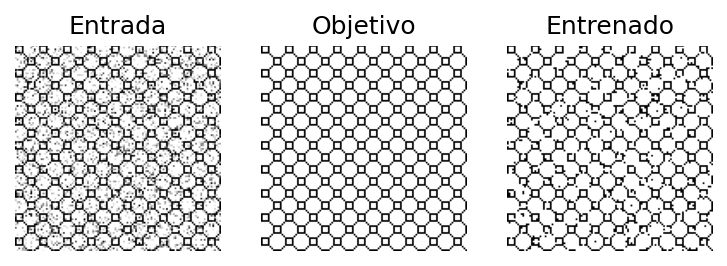

In [46]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
# Valores obtenidos
p = y[0]
fit = y[1]
dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)
#matObj = tf.reshape(matObj, shape = [1, dim[0], dim[1], 1])
# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])
# Validación
imgCeNN = CeNN(matEntR, p, dim, tmax = tmax, h = h)
# Correlación
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
corr = correlacion(imgCeNN, matObj)
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN)))
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
matSal = imgCeNN.numpy()

print("Plantillas: {}".format(p))
print("Tiempo máximo: {}. Paso de tiempo: {}".format(tmax, h))
print("Finess: {}".format(fit))
print("Correlación: {}".format(corr))
print("CS = {}, LimSB = {}, Limites = {}, epocas = {}".format(CS, LimSB, Limites, epocas))

fig, axes = plt.subplots(nrows = 1, ncols = 3, dpi = 150)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].axis('off')
axes[0].set_title("Entrada")
axes[1].imshow(imgObj, cmap = 'gray')
axes[1].axis('off')
axes[1].set_title("Objetivo")
axes[2].imshow(matSal, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title("Entrenado")

# Validación

Correlación Train = 0.7178608775138855
Correlación Global = 0.9055612683296204
Correlación Paper = 0.8807069659233093


(-0.5, 164.5, 149.5, -0.5)

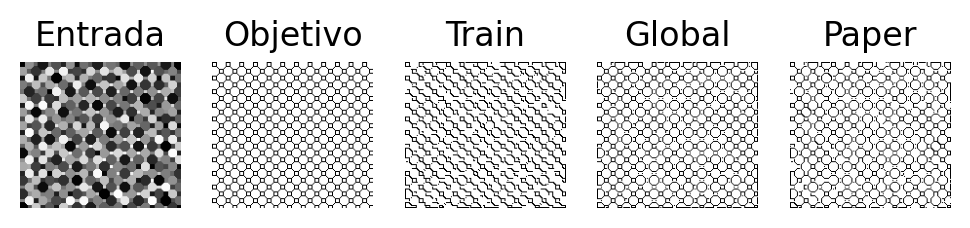

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Grises0_150x165_paso2.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_150x165.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
# Valores obtenidos

dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)

# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])


# ---- Train ----- #
pT = y[0]
fitT = y[1]
tmaxT = tmax
hT = h
imgCeNN = CeNN(matEntR, pT, dim, tmax = tmax, h = h) # CeNN
fitT = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgT = imgCeNN.numpy() # Guarda en formato numpy

# ----- Global ----- #
pG =  np.array([-0.14966108, 0.53145529, -0.16889381, -0.11542056, 63.58460309, 0.1252678, -29.91468367, 0.20578403, -23.72943881, 44.04818551, -0.33098828])
hG = 0.03125
tmaxG = 1.25
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG) # CeNN
fitG = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgG = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper ----- #
pP = np.array([-0.2481, -5.4392, -1.2947, -7.3103, 62.7200, -0.0051, 0.0610, 0.1331, -0.0739, -34.2720, -1.6937])
hP = 0.3
tmaxP = 9.0
imgCeNN = CeNN(matEntR, pP, dim, tmax = tmaxP, h = hP) # CeNN
fitP = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgP = imgCeNN.numpy() # Guarda en formato numpy

# ----- Imprime valores ----- #
print("Correlación Train = {}".format(fitT))
print("Correlación Global = {}".format(fitG))
print("Correlación Paper = {}".format(fitP))

fig, axes = plt.subplots(nrows = 1, ncols = 5, dpi = 200)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].set_title("Entrada")
axes[0].axis('off')
axes[1].imshow(imgObj, cmap = 'gray')
axes[1].set_title("Objetivo")
axes[1].axis('off')
axes[2].imshow(imgT, cmap = 'gray')
axes[2].set_title("Train")
axes[2].axis('off')
axes[3].imshow(imgG, cmap = 'gray')
axes[3].set_title("Global")
axes[3].axis('off')
axes[4].imshow(imgP, cmap = 'gray')
axes[4].set_title("Paper")
axes[4].axis('off')